In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import silhouette_score

In [59]:
df = pd.read_excel('Online Retail.xlsx')

In [60]:
# Групуємо клієнтів за країною
df = df[df['Country'] == 'United Kingdom']

# Видаляємо рядки з нульовими значеннями в стовпцях Description і CustomerID
df = df.dropna(subset=['Description', 'CustomerID'])

# Видаляємо негативні записи в кількості
df = df[df['Quantity'] >= 0]

# Перетворюємо Invoice_Date у формат дати і часу
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Додаємо новий стовпець Total_Amount
df['Total_Amount'] = df['Quantity'] * df['UnitPrice']

# Виведемо перші декілька рядків для перевірки
print(df.head())

  InvoiceNo StockCode                          Description  Quantity   
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  \
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Total_Amount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom         15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom         20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom         22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom         20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom         20.34  


In [61]:
import datetime

# allocate the end date of data
last_date = df['InvoiceDate'].max()

# create rfm dataframe group by customer
data = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max() + datetime.timedelta(days=1)).days,
    'InvoiceNo': lambda x: len(x),  # F (Frequency)
    'Total_Amount': 'sum'  # M (Monetary Value)
}).reset_index()

# set the true name of columns
data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(data.head(5))

   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12747.0        2        103   4196.01
2     12748.0        1       4596  33719.73
3     12749.0        4        199   4090.88
4     12820.0        3         59    942.34


In [62]:
data.shape

(3921, 4)

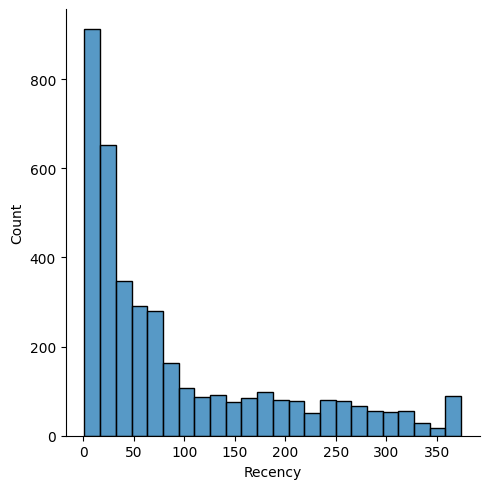

In [63]:
x = data['Recency']
ax = sns.displot(x)

plt.show()

In [64]:
customer_ids = data['CustomerID']
data = data.drop('CustomerID', axis=1)

In [65]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [66]:
X_train, X_test, _, _ = train_test_split(data_scaled, data_scaled, test_size=0.2, random_state=42)

In [67]:
input_layer = Input(shape=(data.shape[1],))
encoded = Dense(2, activation='relu')(input_layer)  # 2 - кількість нейронів у прихованому шарі
decoded = Dense(data.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [68]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [69]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test), callbacks=early_stop)

Epoch 1/50


98/98 [==============================] - 1s 3ms/step - loss: 1.0460 - val_loss: 1.7906
Epoch 2/50
98/98 [==============================] - 0s 3ms/step - loss: 0.9914 - val_loss: 1.7349
Epoch 3/50
98/98 [==============================] - 0s 2ms/step - loss: 0.9354 - val_loss: 1.6802
Epoch 4/50
98/98 [==============================] - 0s 3ms/step - loss: 0.8818 - val_loss: 1.6320
Epoch 5/50
98/98 [==============================] - 0s 2ms/step - loss: 0.8351 - val_loss: 1.5922
Epoch 6/50
98/98 [==============================] - 0s 3ms/step - loss: 0.7972 - val_loss: 1.5602
Epoch 7/50
98/98 [==============================] - 0s 3ms/step - loss: 0.7671 - val_loss: 1.5355
Epoch 8/50
98/98 [==============================] - 0s 3ms/step - loss: 0.7435 - val_loss: 1.5163
Epoch 9/50
98/98 [==============================] - 0s 2ms/step - loss: 0.7250 - val_loss: 1.4994
Epoch 10/50
98/98 [==============================] - 0s 2ms/step - loss: 0.7104 - val_loss: 1.4871
Epoch 11/50
98/98 [===========

In [70]:
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(data_scaled)

123/123 [==============================] - 0s 2ms/step


In [101]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(encoded_data)

C:\Users\ira\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [102]:
data['Cluster'] = kmeans.labels_

In [103]:
result = pd.concat([customer_ids, data], axis=1)

In [104]:
print(result)

      CustomerID  Recency  Frequency  Monetary  Cluster
0        12346.0      326          1  77183.60        2
1        12747.0        2        103   4196.01        1
2        12748.0        1       4596  33719.73        3
3        12749.0        4        199   4090.88        3
4        12820.0        3         59    942.34        1
...          ...      ...        ...       ...      ...
3916     18280.0      278         10    180.60        2
3917     18281.0      181          7     80.82        0
3918     18282.0        8         12    178.05        1
3919     18283.0        4        756   2094.88        3
3920     18287.0       43         70   1837.28        1

[3921 rows x 5 columns]


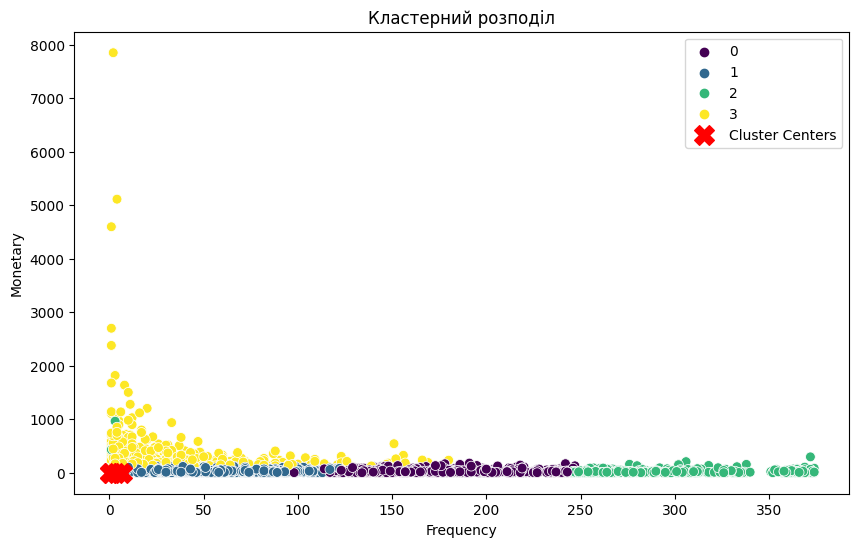

In [105]:
plt.figure(figsize=(10, 6))

# Використовуємо scatter plot для відображення кластерів
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=data, palette='viridis', s=50)

# Додаємо маркери центрів кластерів
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.title('Кластерний розподіл')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()
plt.show()

In [106]:
cluster_0_data = data[data['Cluster'] == 0]
cluster_0_data.shape
cluster_0_data

,Recency,Frequency,Monetary,Cluster
5,214,6,92.72,0
16,145,24,417.38,0
19,173,12,134.10,0
22,144,113,2726.77,0
32,135,78,1957.10,0
...,...,...,...,...
3894,123,47,804.02,0
3902,173,134,2643.20,0
3904,140,13,149.48,0
3907,134,1,25.50,0


In [107]:
cluster_1_data = data[data['Cluster'] == 1]
cluster_1_data.shape
cluster_1_data

,Recency,Frequency,Monetary,Cluster
1,2,103,4196.01,1
4,3,59,942.34,1
6,71,46,948.88,1
7,75,5,1759.50,1
8,60,25,397.12,1
...,...,...,...,...
3913,44,14,335.86,1
3914,58,8,110.38,1
3915,74,9,173.90,1
3918,8,12,178.05,1


In [108]:
cluster_2_data = data[data['Cluster'] == 2]
cluster_2_data.shape
cluster_2_data

,Recency,Frequency,Monetary,Cluster
0,326,1,77183.60,2
12,337,11,293.00,2
14,262,9,215.05,2
17,283,18,312.38,2
27,267,27,354.09,2
...,...,...,...,...
3875,264,10,158.95,2
3884,326,1,440.00,2
3896,310,21,349.27,2
3908,366,7,168.60,2


In [109]:
cluster_3_data = data[data['Cluster'] == 3]
cluster_3_data.shape
cluster_3_data

,Recency,Frequency,Monetary,Cluster
2,1,4596,33719.73,3
3,4,199,4090.88,3
18,59,175,2612.86,3
21,3,314,5591.42,3
23,5,420,4022.35,3
...,...,...,...,...
3877,44,242,5228.05,3
3880,12,164,7276.90,3
3892,7,175,2567.06,3
3910,3,166,3078.58,3


In [110]:
silhouette_avg = silhouette_score(encoded_data, data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.570103645324707


In [111]:
kmeans_2_cluster = KMeans(n_clusters=2)
kmeans_2_cluster.fit(encoded_data)

C:\Users\ira\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [112]:
data['Cluster'] = kmeans_2_cluster.labels_

In [113]:
result_2_cluster = pd.concat([customer_ids, data], axis=1)

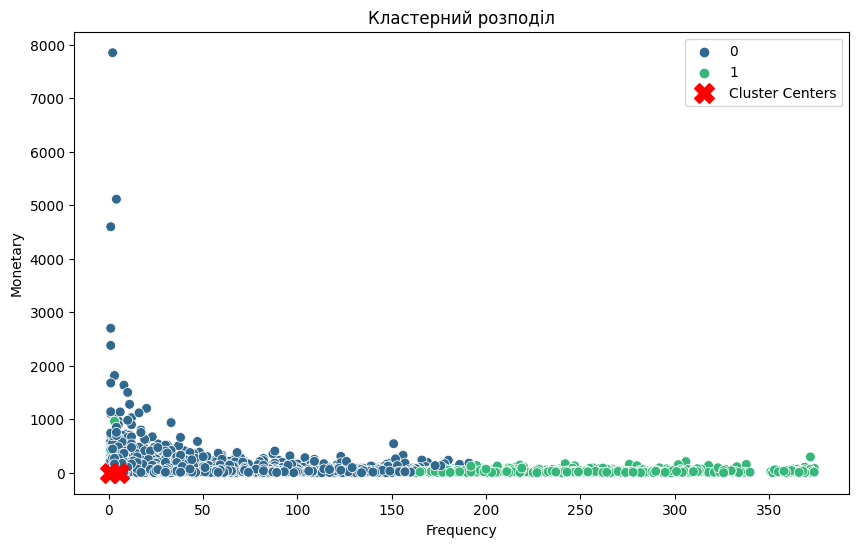

In [114]:
plt.figure(figsize=(10, 6))

# Використовуємо scatter plot для відображення кластерів
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=data, palette='viridis', s=50)

# Додаємо маркери центрів кластерів
centers = kmeans_2_cluster.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

plt.title('Кластерний розподіл')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()
plt.show()

In [115]:
silhouette_avg = silhouette_score(encoded_data, data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6438605785369873
